In [ ]:
import numpy as np
from keras import backend as keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

from sklearn.model_selection import train_test_split

from glob import glob
import cv2

from PIL import Image

import os

from matplotlib import pyplot as plt

import tensorflow.keras.backend as K

2023-12-15 08:26:07.640357: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-15 08:26:08.332569: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-15 08:26:08.338433: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-15 08:26:21.901009: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir("drive/MyDrive/BioCV2023")

In [ ]:
import custom_loss_function as clf
from keras.saving import *
import tensorflow.keras as keras
import warnings

@tf.keras.saving.register_keras_serializable(name="weighted_categorical_crossentropy")
def weighted_categorical_crossentropy(target, output, weights, axis=-1):
    target = tf.convert_to_tensor(target)
    output = tf.convert_to_tensor(output)
    target.shape.assert_is_compatible_with(output.shape)
    weights = tf.reshape(tf.convert_to_tensor(weights, dtype=target.dtype), (1,-1))

    # Adjust the predictions so that the probability of
    # each class for every sample adds up to 1
    # This is needed to ensure that the cross entropy is
    # computed correctly.
    output = output / tf.reduce_sum(output, axis, True)

    # Compute cross entropy from probabilities.
    epsilon_ = tf.constant(tf.keras.backend.epsilon(), output.dtype.base_dtype)     
    output = tf.clip_by_value(output, epsilon_, 1.0 - epsilon_)     # evito di avere valori estremi (0 o 1)
    return -tf.reduce_sum(weights * target * tf.math.log(output), axis=axis)    # reduce perchè avrò 1 "loss" per pixel


# non è molto importante sapere come è costruita, sono cose tecniche anche inutili per il mio scopo
@tf.keras.saving.register_keras_serializable(name="WeightedCategoricalCrossentropy")
class WeightedCategoricalCrossentropy:
    def __init__(
        self,
        weights,
        label_smoothing=0.0,
        axis=-1,
        name="weighted_categorical_crossentropy",
        fn = None,
    ):
        """Initializes `WeightedCategoricalCrossentropy` instance.
        Args:
          from_logits: Whether to interpret `y_pred` as a tensor of
            [logit](https://en.wikipedia.org/wiki/Logit) values. By default, we
            assume that `y_pred` contains probabilities (i.e., values in [0,
            1]).
          label_smoothing: Float in [0, 1]. When 0, no smoothing occurs. When >
            0, we compute the loss between the predicted labels and a smoothed
            version of the true labels, where the smoothing squeezes the labels
            towards 0.5.  Larger values of `label_smoothing` correspond to
            heavier smoothing.
          axis: The axis along which to compute crossentropy (the features
            axis).  Defaults to -1.
          name: Name for the op. Defaults to 'weighted_categorical_crossentropy'.
        """
        super().__init__()
        self.weights = weights # tf.reshape(tf.convert_to_tensor(weights),(1,-1))
        self.label_smoothing = label_smoothing
        self.name = name
        self.fn = weighted_categorical_crossentropy if fn is None else fn

    def __call__(self, y_true, y_pred, axis=-1):
        if isinstance(axis, bool):
            raise ValueError(
                "`axis` must be of type `int`. "
                f"Received: axis={axis} of type {type(axis)}"
            )
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)
        self.label_smoothing = tf.convert_to_tensor(self.label_smoothing, dtype=y_pred.dtype)

        if y_pred.shape[-1] == 1:
            warnings.warn(
                "In loss categorical_crossentropy, expected "
                "y_pred.shape to be (batch_size, num_classes) "
                f"with num_classes > 1. Received: y_pred.shape={y_pred.shape}. "
                "Consider using 'binary_crossentropy' if you only have 2 classes.",
                SyntaxWarning,
                stacklevel=2,
            )

        def _smooth_labels():
            num_classes = tf.cast(tf.shape(y_true)[-1], y_pred.dtype)
            return y_true * (1.0 - self.label_smoothing) + (self.label_smoothing / num_classes)

        y_true = tf.__internal__.smart_cond.smart_cond(self.label_smoothing, _smooth_labels, lambda: y_true)

        return tf.reduce_mean(self.fn(y_true, y_pred, self.weights, axis=axis))
    
    def get_config(self):
        config = {"name":self.name, "weights": self.weights, "fn": weighted_categorical_crossentropy}

        # base_config = super().get_config()
        return dict(list(config.items()))

    @classmethod
    def from_config(cls, config):
        """Instantiates a `Loss` from its config (output of `get_config()`).
        Args:
            config: Output of `get_config()`.
        """
        return cls(**config)


### Hyperparameters

In [ ]:
IMAGE_SIZE = 256
num_classes = 6    # now I have 6 classes, because I added the body mask
batch = 4
LR = 1e-4
EPOCHS = 5
NUM_IMAGES = 522

### Funzioni ausiliare
Qui sotto sono implementate funzioni per la creazione del dataset:
* caricamento percorsi
* divisione training/validation/test set
* caricamento e preprocessing immagini + maschere
* data augmentationc

In [ ]:
image_path = "./Preprocessed_Set/T1DUAL/OutPhase/Images/"  # da inserire
regex_images_paths = os.path.join(image_path, "*.png")
mask_path = "./Preprocessed_Set/T1DUAL/OutPhase/Masks/"   # da inserire
regex_masks_paths = os.path.join(mask_path, "*.png")
checkpoint_path = "./checkpoints/checkpoint1"

# carica i percorsi dei dati separandoli in 80% training, 10% validation, 10% test
def load_data():
  images_paths = sorted(glob(regex_images_paths))
  masks_paths = sorted(glob(regex_masks_paths))
  train_x, tmp_x, train_y, tmp_y = train_test_split(images_paths, masks_paths, test_size=0.2, random_state=42, shuffle=True)
  valid_x, test_x, valid_y, test_y = train_test_split(tmp_x, tmp_y, test_size=0.5, random_state=42, shuffle=True)

  return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)


In [ ]:
# NON UTILIZZATO PER ORA PERCHE' MI GENERA STRANE IMMAGINI
data_augmentation = tf.keras.Sequential([
  RandomFlip("vertical"), # could be "horizontal_and_vertical", but is it meaningful?
  RandomRotation(0.2),
  RandomZoom(.5, .2),
  RandomContrast(0.1)],
  )

In [ ]:
# carica l'immagine, normalizzandola a 0-1
def read_image(path):
    path = path.decode()
    x = np.array(Image.open(path))
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE), interpolation=0)
    #x = x.astype(float)/255.0
    x = x/255.0
    return x

# carica la maschera
def read_mask(path):
    path = path.decode()
    x = np.array(Image.open(path))
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE), interpolation=0)
    x = K.cast(K.one_hot(x, num_classes=num_classes), tf.uint8)
    #x = np.expand_dims(x, axis=-1) #why would I need this?
    return x

# mi carica una coppia immagine-maschera
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.uint8])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, num_classes])
    return x, y

# SIAMO SICURI CHE QUESTO FACCIA DATA AUGMENTATION? perchè sto semplicemente prendendo una coppia (x,y) e, con una certa probabilità, modifico x
# quindi 1. non modifico y
#        2. non genero nuovi esempi
# mi crea il dataset di training
def tf_dataset_train(x, y, batch=4):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))    # creo il dataset con i percorsi...
    dataset = dataset.shuffle(buffer_size=500)
    dataset = dataset.repeat()
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)    # e qui "risolvo" i percorsi
    dataset = dataset.batch(batch)
    #dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    # per data_augmentation nella libreria usa predict, invece di usare __call__, dove predict può essere eseguito su una batch alla volta e non su tutto l'input insieme
    # in questo caso credo sia indifferente, essendo una operazione "statica", che cioè non faccio durante l'allenamento del modello
    dataset = dataset.prefetch(1)       # per caricare in anticipo anche 1 elemento dopo
    return dataset

def tf_dataset_valid(x, y, batch=batch):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=50)
    dataset = dataset.repeat()
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(1)
    return dataset


### Creazione modello Unet
Qui viene implementato il modello Unet. Da notare:
* non utilizzo come encoder una rete preesistente (tipicamente MobileNet) per semplicità
* l'output della CNN è una matrice di dimensione `(row_img, col_img, num_classes)`, dove, per ogni pixel _p_ per ogni classe _i_ assegno una probabilità (tramite softmax) al pixel di appartenere alla classe _i_

In [ ]:

# pretrained weights: ho già addestrato un po' una rete e voglio continuare ad addestrare partendo da quei parametri
# utile se google mi interrompe l'esecuzione su Colab
def unet(pretrained_weights = None,input_size = (256,256, 1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # upsampling + convoluzione 2d di solito fatta con un'unica fz: transpose convolution
    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)   # concateno l'output del layer di dropout a quello della up convolution di prima -> da la forma a U della U-Net
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(num_classes, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(num_classes, 1, activation = 'softmax')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    #model.compile(optimizer = Adam(learning_rate = 1e-4), loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['accuracy'])   # posso usare metriche implementate da me (callbacks)
    model.compile(optimizer = Adam(learning_rate = 1e-4), loss = clf.WeightedCategoricalCrossentropy([0.01, 10, 10, 10, 10, 10]), metrics = ['accuracy'])   # posso usare metriche implementate da me (callbacks)

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

## Creazione modello e training

### Creazione del dataset

In [ ]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data()

train_dataset = tf_dataset_train(train_x, train_y)
valid_dataset = tf_dataset_valid(valid_x, valid_y)
test_dataset = tf_dataset_valid(test_x, test_y)

In [ ]:
model = unet()

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='auto',
    save_best_only=True)

#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True)

(None, 256, 256, 5) (None, 256, 256, 5)


In [ ]:
# Commencement of training
train_steps = len(train_x)//batch
valid_steps = len(valid_x)//batch

if len(train_x) % batch != 0:   ## equivale a fare ceil() nelle equazioni di prima
    train_steps += 1
if len(valid_x) % batch != 0:
    valid_steps += 1

model.fit(
    train_dataset,
    validation_data = valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=[model_checkpoint_callback]
    #callbacks=[model_checkpoint_callback, early_stopping, reduce_lr]
)

Epoch 1/5
105/105 [==============================] - 53s 403ms/step - loss: nan - accuracy: 0.9469 - val_loss: nan - val_accuracy: 0.9441
Epoch 2/5
105/105 [==============================] - 34s 323ms/step - loss: nan - accuracy: 0.9560 - val_loss: nan - val_accuracy: 0.9441
Epoch 3/5
105/105 [==============================] - 33s 319ms/step - loss: nan - accuracy: 0.9565 - val_loss: nan - val_accuracy: 0.9441
Epoch 4/5
105/105 [==============================] - 34s 320ms/step - loss: nan - accuracy: 0.9560 - val_loss: nan - val_accuracy: 0.9441
Epoch 5/5
105/105 [==============================] - 34s 320ms/step - loss: nan - accuracy: 0.9569 - val_loss: nan - val_accuracy: 0.9441


In [ ]:
def mask_from_prob(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    return pred_mask

In [ ]:

def display_sample(display_list):
    plt.figure(figsize=(16, 16))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def show_predictions():
    prediction = model.predict(sample_image)

    pred_mask = mask_from_prob(prediction[0])
    plt.subplot(1, 3, 1)
    plt.imshow(sample_image[0], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.imshow(sample_mask[0], cmap="gray")
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap="gray")

for image, mask in test_dataset.take(1):
    sample_image, sample_mask = image, mask

show_predictions()

In [ ]:
model = tf.keras.models.load_model(checkpoint_path)

In [ ]:
loss, acc = model.evaluate(test_dataset, verbose=2, steps=20)

20/20 - 4s - loss: nan - accuracy: 0.9463 - 4s/epoch - 216ms/step


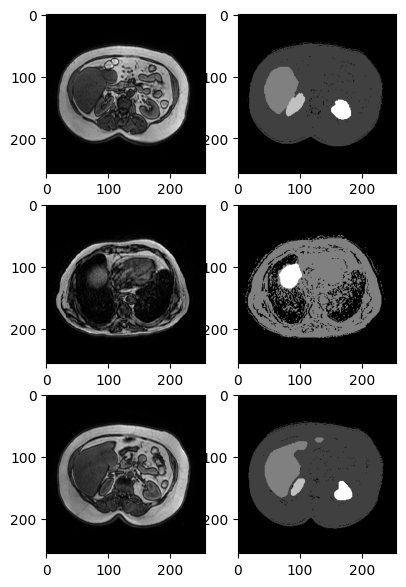

In [ ]:
for (x,y) in valid_dataset.take(1):
    imgs, msks = x,y

plt.figure(figsize=(7,7))
true_msks = [mask_from_prob(msks[i]) for i in range(batch)]
#predictions = model.predict(imgs)
#pred_masks = [mask_from_prob(predictions[i]) for i in range(4)]
for i in range(3):
    plt.subplot(3,3,3*i+1)
    plt.imshow(imgs[i], cmap="gray")
    plt.subplot(3,3,3*i+2)
    plt.imshow(true_msks[i], cmap="gray")
    #plt.subplot(3,3,3*i+3)
    #plt.imshow(pred_masks[i], cmap="gray")